In [176]:
import torch

import torchvision
import torchvision.transforms as transforms

from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
from score_utils import *
from tqdm import tqdm
import sys

from scipy import signal
import random

np.set_printoptions(threshold=sys.maxsize)


device = "cuda:0"

transform = transforms.Compose([
    transforms.ToTensor(),
])
trainset = torchvision.datasets.MNIST('/media/data1/data/MNIST', train = True, transform = transform, download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, num_workers=4)


def gkern(kernlen=21, std_1=3, std_2=3):
    """Returns a 2D Gaussian kernel array."""
    gkern1d_1 = signal.gaussian(kernlen, std=std_1).reshape(kernlen, 1)
    gkern1d_2 = signal.gaussian(kernlen, std=std_2).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d_1, gkern1d_2)
    return gkern2d


def get_noise(c, img_size):
    ker_size = random.randint(7, img_size//2)
    std1 = (random.random()+1)*3
    std2 = (random.random()+1)*3
    
    sign = random.randint(1,2)
    if sign==2:
        sign = -1
    noise_strength = random.randint(10,20)/100
    noise = gkern(ker_size, std1, std2) * noise_strength * sign
    noise = np.expand_dims(noise, axis = 0)
    noise = np.repeat(noise, c, axis = 0)
    
    x = random.randint(0, img_size-ker_size)
    y = random.randint(0, img_size-ker_size)

    return {'x': x,
            'y': y,
            'noise': noise}

def get_noisy_data(data, noise_list):
    data_tmp = data.copy()
    for noise in noise_list:
        x, y = noise['x'], noise['y']
        ker_size = noise['noise'].shape[1]
        
        data_tmp[:, x:x+ker_size, y:y+ker_size] += noise['noise']
    
    data_tmp = np.clip(data_tmp, 0, 1)
    
    return data_tmp




In [177]:
train_bar = tqdm(trainloader)
data_origin = []
data_noisy = []
data_label = []

test_origin = []
test_noisy = []
test_label = []

cnt = 0
for data, target in train_bar:
    data = data.numpy()[0]
    target = target.numpy()[0]
    c, w, h = data.shape
    
    noise_num = random.randint(20, 40)
    noise_arr = [get_noise(c, w) for _ in range(noise_num)]
    
    noisy_data = get_noisy_data(data, noise_arr)
    
    if cnt < 50000:
        data_origin.append(data)
        data_noisy.append(noisy_data)
        data_label.append(target)
        
    else:
        test_origin.append(data)
        test_noisy.append(noisy_data)
        test_label.append(target)
        
    cnt += 1



data_origin = np.array(data_origin)
data_noisy = np.array(data_noisy)
data_label = np.array(data_label)


test_origin = np.array(test_origin)
test_noisy = np.array(test_noisy)
test_label = np.array(test_label)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [03:23<00:00, 294.59it/s]


In [178]:
print(data_origin.shape)
print(data_noisy.shape)
print(data_label.shape)

print(test_origin.shape)
print(test_noisy.shape)
print(test_label.shape)

(50000, 1, 28, 28)
(50000, 1, 28, 28)
(50000,)
(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000,)


In [179]:
np.save("train_original", data_origin)
np.save("train_noisy", data_noisy)
np.save("train_label", data_label)

np.save("test_original", test_origin)
np.save("test_noisy", test_noisy)
np.save("test_label", test_label)

0.0
1.0
(50000, 1, 28, 28)


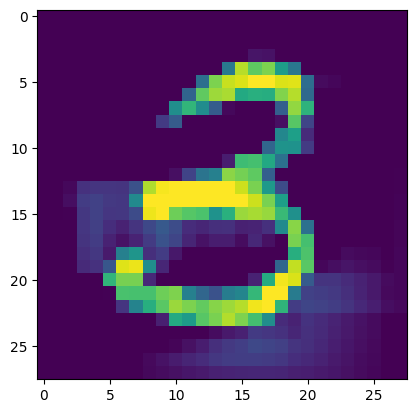

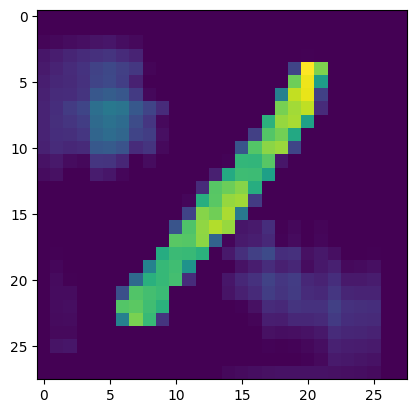

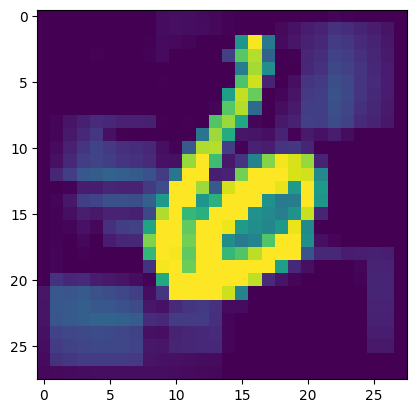

In [180]:

from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt


class ClassDataset(Dataset):

    def __init__(self, data, noisy):
        self.data = data
        self.noisy = noisy  
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        target = self.noisy[idx]

        return data, target


if __name__ == "__main__":
    original = np.load('./train_original.npy')
    noisy = np.load('./train_noisy.npy')
    print(np.min(original))
    print(np.max(original))
    print(original.shape)
    dataset = ClassDataset(original, noisy)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True, drop_last=False)
    #data_bar = tqdm(dataloader)
    for data, target in dataloader:
        
        plt.imshow(target[0][0])
        plt.show()
        break
    
    for data, target in dataloader:
        
        plt.imshow(target[0][0])
        plt.show()
        break
    print('\n')
    
    data, target = next(iter(dataloader))
    
    plt.imshow(target[0][0])
    plt.show()
    